### Load libraries

In [36]:
import dataclasses
from typing import Collection, Optional

import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import scipy.stats
from thundersvm import SVC
from tqdm.auto import tqdm

plt.style.use('ggplot')

### Helper functions

In [2]:
def normalized(x: np.ndarray) -> np.ndarray:
    return x / np.linalg.norm(x)


@dataclasses.dataclass
class BinaryDataset:
    mu: np.ndarray
    sep: float

    xs: np.ndarray
    ys: np.ndarray

    @classmethod
    def _gen_data(
        cls,
        n_train: int,
        d: int,
        sep: float,
        mu: Optional[np.ndarray] = None,
    ):
        # TODO(Tony): Pass seed in for rng
        if mu is None:
            mu = np.random.normal(size=d)
        mu = normalized(mu)

        xs = sep * mu.reshape(1, -1) + np.random.normal(size=(n_train, d))

        mask = np.random.randint(low=0, high=2, size=(n_train), dtype=bool)
        xs[mask, :] *= -1

        ys = ((xs @ mu) > 0).astype(np.int64)

        # NOTE: We need to make the first class 1 to make SVC work.
        if ys[0] == 0:
            ys = 1 - ys
            xs *= -1

        return cls(mu=mu, sep=sep, xs=xs, ys=ys)

    @classmethod
    def gen_data(
        cls,
        n_train: int,
        d: int,
        sep: float,
        mu: Optional[np.ndarray] = None,
    ):
        """Gaurantees both classes will be present"""
        assert n_train >= 2
        ds = cls._gen_data(n_train=n_train, d=d, sep=sep, mu=mu)
        while ds.ys.sum() in (0, n_train):
            ds = cls._gen_data(n_train=n_train, d=d, sep=sep, mu=mu)
        return ds


BinaryDataset.gen_data(n_train=3, d=3, sep=0)


BinaryDataset(mu=array([0.95194312, 0.0120887 , 0.30603621]), sep=0, xs=array([[ 0.76785728, -0.72741892, -0.94277653],
       [ 0.18154998,  1.48557577, -0.14738455],
       [-2.28397899, -1.56795765,  0.25164486]]), ys=array([1, 1, 0]))

In [3]:
@dataclasses.dataclass
class LinClf:
    raw_w: np.ndarray
    raw_b: np.ndarray

    def __post_init__(self):
        self.w = normalized(self.raw_w)
        self.b = self.raw_b / np.linalg.norm(self.raw_w)

    @classmethod
    def from_svc(cls, svc: SVC):
        return cls(
            raw_w=(svc.dual_coef_[0] @ svc.support_vectors_)[1:],
            raw_b=-svc.intercept_[0],
        )

    @classmethod
    def from_svm(cls, ds: BinaryDataset, c: float = 1):
        assert ds.ys[0] == 1
        svc = SVC(C=c, kernel="linear")
        svc.fit(ds.xs, ds.ys)
        return cls.from_svc(svc)

    def raw_decision_function(self, xs: np.ndarray):
        return xs @ self.raw_w + self.raw_b

    def pred(self, xs: np.ndarray) -> np.ndarray:
        return ((xs @ self.w + self.b) > 0).astype(np.int64)

    def empirical_err(self, ds: BinaryDataset) -> float:
        return (self.pred(xs=ds.xs) != ds.ys).mean()

    def analytic_err(self, mu: np.ndarray, sep: float) -> float:
        """
        We want to calculate
        res = P(x @ mu >  0 and x @ w + b <= 0)
            + P(x @ mu <= 0 and x @ w + b >  0)

        Case: x ~ N(mu * sep, I)
        Then:
              x @ mu ~ N(sep, 1)
              x @ w + b ~ N(sep * mu @ w + b, 1)

              Cov(x @ mu, x @ w + b)
            = Cov(x @ mu, x @ w)
            = Cov(z @ mu, z @ w) (where z ~ N(0, I))
            = E [(z^t mu)^t (z^t w)]
            = mu^t E [(z z^t)] w
            = mu @ w

        Case: x ~ N(-mu * sep, I)
        Then:
              x @ mu ~ N(-sep, 1)
              x @ w + b ~ N(-sep * mu @ w + b, 1)

              Cov(x @ mu, x @ w + b)
            = mu @ w

        Thus:
                res = P(A > 0 and B <= 0) + P(A <= 0 and B > 0)
            where [A, B] ~ N([sep, sep * mu @ w + b], [[1, mu@w], [mu@w, 1]])
        """

        def get_prob(m1: float, m2: float, c12: float) -> float:
            """
            Returns P(A > 0 and B <= 0) + P(A <= 0 and B > 0)
            assuming [A, B] ~ N([m1, m2], [[1, c12], [c12, 1]])
            """
            prob0: float = scipy.stats.multivariate_normal(
                mean=(-m1, m2),
                cov=((1, -c12), (-c12, 1)),  # type: ignore
            ).cdf(np.zeros(2))

            prob1: float = scipy.stats.multivariate_normal(
                mean=(m1, -m2),
                cov=((1, -c12), (-c12, 1)),  # type: ignore
            ).cdf(np.zeros(2))

            return prob0 + prob1

        return (
            get_prob(sep, sep * mu @ self.w + self.b, mu @ self.w)  # type: ignore
            + get_prob(-sep, -sep * mu @ self.w + self.b, mu @ self.w)  # type: ignore
        ) / 2

# np.random.seed(0)
ds_train = BinaryDataset.gen_data(n_train=100, d=10, sep=3)
ds_test = BinaryDataset.gen_data(
    n_train=1_000_000, d=10, sep=ds_train.sep, mu=ds_train.mu
)

clf = LinClf.from_svm(ds_train, c=10)
print("Empirical err:", clf.empirical_err(ds_test))
print("Analytic err:", clf.analytic_err(sep=ds_test.sep, mu=ds_test.mu))

Empirical err: 0.001118
Analytic err: 0.0012221970168625443


In [4]:
# Small test

ds = BinaryDataset.gen_data(n_train=1000, d=4, sep=0)
clf = LinClf.from_svm(ds, c=10)
svc = SVC(C=10, kernel="linear")
svc.fit(ds.xs, ds.ys)

assert np.allclose(
    clf.raw_decision_function(ds.xs),
    svc.decision_function(ds.xs).flatten(),
    rtol=1e-4,
    atol=1e-4,
)


### Scaling experiments

In [17]:
@dataclasses.dataclass
class ScalingResult:
    d: int
    sep: float
    n_trains: np.ndarray

    empirical_errs: np.ndarray
    analytic_errs: np.ndarray

    def __post_init__(self):
        assert (
            self.n_trains.shape
            == self.empirical_errs.shape
            == self.analytic_errs.shape
        )


def run_svm_experiment(
    n_trains_raw: Collection[int],
    sep: float,
    d: int,
    c: float,
    n_test: int = 10_000,
    use_pbar: bool = True,
) -> ScalingResult:
    n_trains: np.ndarray = np.array(sorted(list(set(n_trains_raw))))

    ds_test = BinaryDataset.gen_data(n_train=n_test, d=d, sep=sep)

    empirical_errs: list[float] = []
    analytic_errs: list[float] = []
    pbar = tqdm(n_trains, leave=False) if use_pbar else n_trains
    for n in pbar:
        ds = BinaryDataset.gen_data(n_train=n, d=d, sep=sep, mu=ds_test.mu)
        clf = LinClf.from_svm(ds, c=c)

        empirical_errs.append(clf.empirical_err(ds_test))
        analytic_errs.append(clf.analytic_err(sep=ds.sep, mu=ds.mu))

        if use_pbar:
            pbar.set_description(f"err={analytic_errs[-1]}")

    return ScalingResult(
        d=d,
        sep=sep,
        n_trains=n_trains,
        empirical_errs=np.array(empirical_errs),
        analytic_errs=np.array(analytic_errs),
    )


In [6]:
sep0_res = run_svm_experiment(
    n_trains_raw=[2**i for i in range(1, 20)],
    d=100,
    sep=0,
    c=1,
)

  0%|          | 0/19 [00:00<?, ?it/s]

In [43]:
sep6_res = [
    run_svm_experiment(
        n_trains_raw=list(range(2, 128)) + [200, 400, 1000, 10000],
        d=100,
        sep=6,
        c=1,
        use_pbar=False
    )
    for _ in tqdm(range(50))
]


  0%|          | 0/50 [00:00<?, ?it/s]

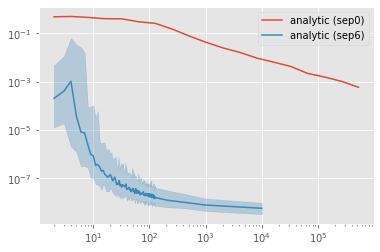

In [44]:
plt.plot(sep0_res.n_trains, sep0_res.analytic_errs, label="analytic (sep0)")
# plt.plot(sep0_res.n_trains, sep0_res.empirical_errs, label="empirical (sep0)")

sep6_errs = np.stack([r.analytic_errs for r in sep6_res])
sep6_lo = np.quantile(sep6_errs, q=0.05, axis=0)
sep6_mid = np.quantile(sep6_errs, q=0.5, axis=0)
sep6_hi = np.quantile(sep6_errs, q=0.95, axis=0)
plt.plot(sep6_res[0].n_trains, sep6_mid, label="analytic (sep6)")
plt.fill_between(
    x=sep6_res[0].n_trains,
    y1=sep6_lo,
    y2=sep6_hi,
    alpha=0.25,
    color="tab:blue",
)
# plt.plot(
#     sep6_res[0].n_trains,
#     np.median(spe6_errs, axis=0),
#     label="analytic (sep6)",
# )

# plt.plot(sep2_res.n_trains, sep2_res.analytic_errs, label="analytic (sep2)")
# plt.plot(sep2_res.n_trains, sep2_res.empirical_errs, label="empirical (sep2)")
plt.yscale("log")
plt.xscale("log")
plt.legend();